## do why

<img src="do-why.webp" alt="do-why" width="450">

*packages*

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# graphs
import networkx as nx

# do why
from dowhy.utils import plot
from dowhy.utils import bar_plot
from dowhy import gcm

# packages
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import os, yaml, requests
np.random.seed(42)

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

*functions*

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

*create the connection to the db*

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

*get all the data from the db*

In [4]:
q = """
    select
            *
    from
            kaggle_data.revenue_forecast.data;
"""

df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763


In [5]:
df=df_raw.copy()
df.drop(columns=['Cuisine_Type'], inplace=True)
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,36.236133,0,45,350.91204


In [6]:
cols=['number of customers', 'menu price', 'marketing spend', 'avg customer spending', 'promotions', 
      'reviews', 'monthly revenue']

df.columns=cols
df.head(1)

,number of customers,menu price,marketing spend,avg customer spending,promotions,reviews,monthly revenue
0,61,43.117635,12.663793,36.236133,0,45,350.91204


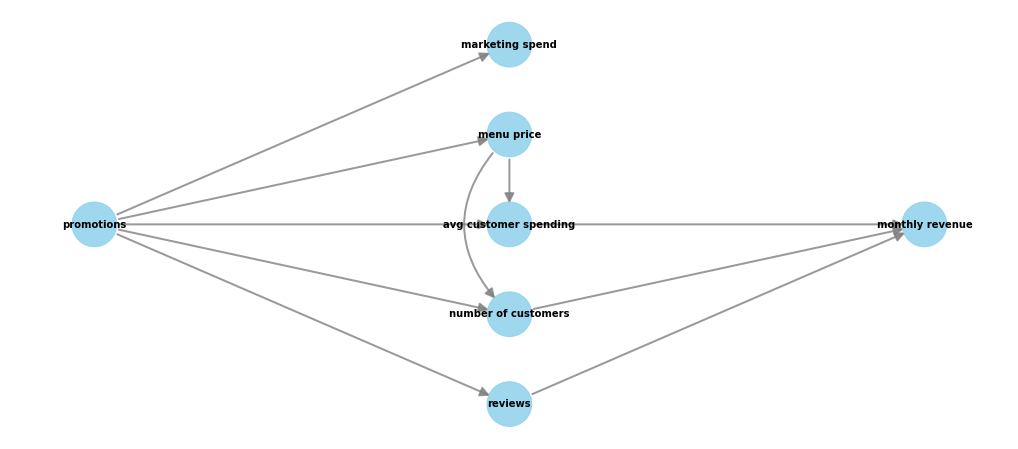

In [7]:
causal_graph=nx.DiGraph([('promotions', 'marketing spend'),
                         ('promotions', 'menu price'),
                         ('promotions', 'avg customer spending'),
                         ('promotions', 'number of customers'),
                         ('promotions', 'reviews'),
                         ('menu price', 'number of customers'),
                         ('menu price', 'avg customer spending'),
                         ('avg customer spending', 'monthly revenue'),
                         ('number of customers', 'monthly revenue'),
                         ('reviews', 'monthly revenue'),])

plot(causal_graph, figure_size=(18,8))

In the above graph, we aim to explore the causal relationship between promotions and pricing, and subsequently, their impact on monthly revenue. The main objective is to determine whether a causal relationship exists and how it can be complemented by the SHAP values from the predictive model.

In [8]:
from dowhy import gcm

# structural causal model object
scm=gcm.StructuralCausalModel(causal_graph)

auto_assignment_summary=gcm.auto.assign_causal_mechanisms(scm, 
                                                          df,
                                                          override_models=True,
                                                          quality=gcm.auto.AssignmentQuality.GOOD)

In [9]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [10]:
gcm.fit(scm, df)

Fitting causal mechanism of node monthly revenue: 100%|█| 7/7 [


Evaluating causal mechanisms...: 100%|█| 7/7 [00:00<00:00, 2084
Test permutations of given graph: 100%|█| 50/50 [00:52<00:00,  


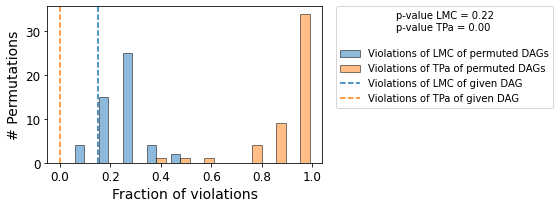

Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked P

In [11]:
print(gcm.evaluate_causal_model(scm, 
                                df, 
                                compare_mechanism_baselines=True, 
                                evaluate_invertibility_assumptions=False))

In [12]:
gcm.draw_samples(scm, num_samples=20)

,promotions,marketing spend,menu price,reviews,number of customers,avg customer spending,monthly revenue
0,1,3.855297,50.405257,22,64,21.606159,271.586339
1,1,2.598598,43.011444,29,51,38.943436,182.824222
2,0,5.079497,40.839357,93,54,25.680701,301.666147
3,1,2.005396,22.959602,33,10,42.741789,118.198069
4,1,17.378885,19.720320,65,81,11.198247,317.634042
5,1,3.734466,31.976570,5,67,38.082211,465.210815
6,1,9.804266,48.362992,11,26,43.109177,180.488599
7,1,2.005396,34.990451,98,50,36.929673,198.984531
8,1,7.982004,24.214498,47,82,20.333459,294.540534
9,1,13.154992,29.770954,27,19,42.437806,245.025419


In [13]:
iccs=gcm.intrinsic_causal_influence(scm,
                                    target_node='monthly revenue',
                                    num_samples_randomization=500)

Estimating Shapley Values. Average change of Shapley values in 


In [15]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

Our analysis reveals that the number of customers significantly impacts monthly revenue, with a smaller contribution from promotions and average customer spending. SHAP values highlight that the number of customers and marketing efforts are the most influential factors, while promotions have only a marginal effect.

In this case, promotions continue to show marginal contribution. Unlike SHAP values which indicate the importance of reviews, there is no causal attribution of reviews in our current findings.

One hypothesis for the results is that the number of customers might depend on the location of the business, such as being situated on an avenue or street, having parking availability, or the quality of service offered. The quality of service can affect both the number of customers and the pricing of the menu.

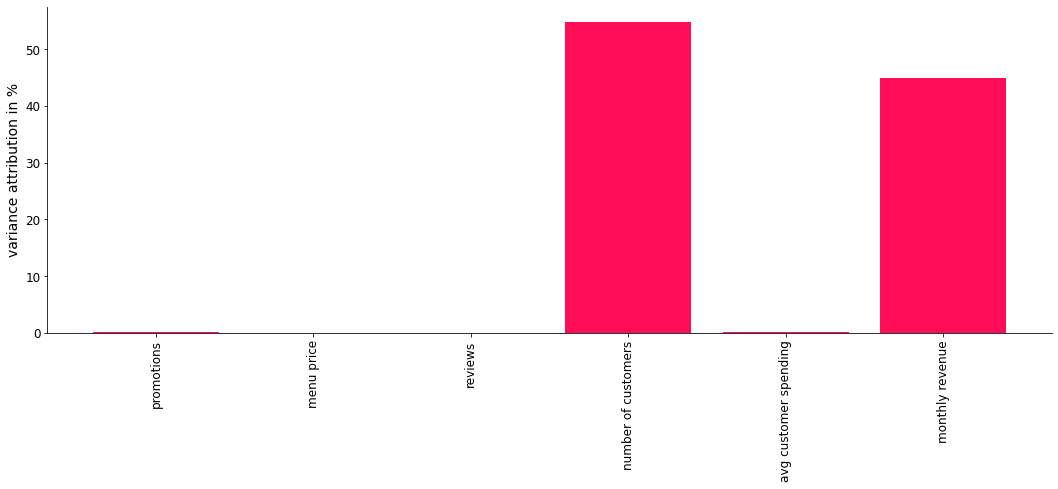

In [16]:
bar_plot(convert_to_percentage(iccs), 
         ylabel='variance attribution in %',
         figure_size=(18,6))

In [17]:
# revenue median
revenue_median=df['monthly revenue'].median()
print(f'monthly revenue median: {revenue_median}')

monthly revenue median: 270.2139642707142


In [18]:
condition=df['monthly revenue']>=revenue_median
high_revenue=df[condition]
low_revenue=df[~condition]

In [21]:
median_attributions, confidence_intervals = gcm.confidence_intervals(
    lambda: gcm.distribution_change(scm,
                                    high_revenue,
                                    low_revenue,
                                    target_node='monthly revenue',
                                    # Here, we are intersted in explaining the differences in the mean.
                                    difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x))
)

  0%|                                    | 0/1 [00:00<?, ?it/s]
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating bootstrap interval...:  75%|▊| 15/20 [07:52<02:23, 2
  0%|                                    | 0/1 [00:00<?, ?it/s]
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating bootstrap interval...:  90%|▉| 18/20 [09:19<00:58, 2
  0%|                                    | 0/1 [00:00<?, ?it/s]
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average change of Shapley values in 
Estimating Shapley Values. Average chang

In the case of attribution, it is evident that the number of customers has a significant negative impact on the revenue of the sites. Following results mentioned earlier, it is clear that increasing the number of customers is crucial for boosting revenue. However, simply increasing the customer count may not be the only solution. Enhancing various other factors could also contribute to revenue growth.

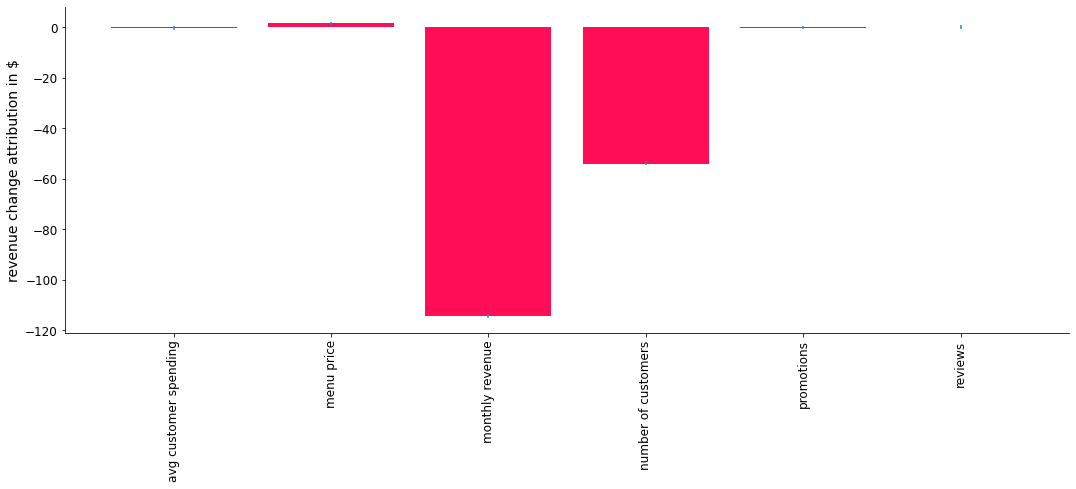

In [26]:
bar_plot(median_attributions, 
         confidence_intervals, 
         figure_size=(18,6),
         ylabel='revenue change attribution in $')

### *`revenue boost strategy`*

In [2]:
org=pd.read_excel('output/original.xlsx')      # source data
sc0=pd.read_excel('output/scenario-0.xlsx')    # dice scenario 0
sc1=pd.read_excel('output/scenario-1.xlsx')    # dice scenario 1
sc2=pd.read_excel('output/scenario-2.xlsx')    # dice scenario 2

# adjust the columns name

sc0.columns=org.columns
sc1.columns=org.columns
sc2.columns=org.columns

# features to observe
features_vary=['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 
               'Reviews', 'revenue_per_customer', 'relative_menu_price', 'reviews_to_revenue_ratio']

The results clearly indicate that to boost the average revenue of the sites, we must implement a combination of diverse strategies for each feature. The key focus should be on increasing the revenue per customer, which will ultimately optimize the current situation.

In [14]:
pd.concat([pd.DataFrame(sc0[features_vary].mean(), columns=['scenario-0']),
           pd.DataFrame(sc1[features_vary].mean(), columns=['scenario-1']),
           pd.DataFrame(sc2[features_vary].mean(), columns=['scenario-2']),
           pd.DataFrame(org[features_vary].mean(), columns=['original'])], axis=1)

,scenario-0,scenario-1,scenario-2,original
Number_of_Customers,54.733766,54.935065,53.103896,42.779221
Menu_Price,29.335699,29.511444,29.173515,28.931551
Marketing_Spend,9.273759,9.081952,9.511750,9.023706
Average_Customer_Spending,30.385229,30.211081,29.804352,29.869027
Reviews,47.837662,46.012987,47.649351,48.824675
revenue_per_customer,10.919980,11.950459,11.831134,6.206805
relative_menu_price,1.385100,1.428736,1.359358,1.212881
reviews_to_revenue_ratio,63.836638,36.677135,54.234726,11.856691


*`scenario 0`*

The table above outlines the necessary changes to improve site revenue. Key highlights include:

- **Number of Customers**: We need to increase the average number of customers by 12 per site, representing a 28% growth.
- **Menu Price**: The menu price requires a modest increase of only 1.4%.
- **Revenue per Customer**: The most significant challenge is raising the revenue per customer by 75%, which is a substantial increase.

In [19]:
scenario0=pd.concat([pd.DataFrame(sc0[features_vary].mean(), columns=['scenario-0']),
                     pd.DataFrame(org[features_vary].mean(), columns=['original'])], axis=1)

scenario0['change']=scenario0['scenario-0']-scenario0['original']
scenario0['pct-change']=round(((scenario0['scenario-0']/scenario0['original'])-1)*100, 2)
scenario0

,scenario-0,original,change,pct-change
Number_of_Customers,54.733766,42.779221,11.954545,27.94
Menu_Price,29.335699,28.931551,0.404149,1.40
Marketing_Spend,9.273759,9.023706,0.250054,2.77
Average_Customer_Spending,30.385229,29.869027,0.516201,1.73
Reviews,47.837662,48.824675,-0.987013,-2.02
revenue_per_customer,10.919980,6.206805,4.713176,75.94
relative_menu_price,1.385100,1.212881,0.172220,14.20
reviews_to_revenue_ratio,63.836638,11.856691,51.979947,438.40


*`scenario 1`*

Continuing with the analysis, we delve into the results of Scenario 1, which reveal the following:

- **Number of Customers**: Similar to previous scenarios, we need to increase the average number of customers by 12 per site, representing a 28% growth.
- **Menu Price**: The menu price requires a modest increase of only 2%.
- **Revenue per Customer**: The primary concern is the need to boost revenue per customer by 92%, a substantial increase that may not be feasible in the short term.

In [20]:
scenario1=pd.concat([pd.DataFrame(sc1[features_vary].mean(), columns=['scenario-1']),
                     pd.DataFrame(org[features_vary].mean(), columns=['original'])], axis=1)

scenario1['change']=scenario1['scenario-1']-scenario0['original']
scenario1['pct-change']=round(((scenario1['scenario-1']/scenario0['original'])-1)*100, 2)
scenario1

,scenario-1,original,change,pct-change
Number_of_Customers,54.935065,42.779221,12.155844,28.42
Menu_Price,29.511444,28.931551,0.579894,2.00
Marketing_Spend,9.081952,9.023706,0.058246,0.65
Average_Customer_Spending,30.211081,29.869027,0.342054,1.15
Reviews,46.012987,48.824675,-2.811688,-5.76
revenue_per_customer,11.950459,6.206805,5.743654,92.54
relative_menu_price,1.428736,1.212881,0.215856,17.80
reviews_to_revenue_ratio,36.677135,11.856691,24.820444,209.34


*`scenario 2`*

Finalizing with the last scenario, we delve into the key features:

- **Number of Customers**: We need to increase the number of customers by an average of 10 per site, representing a 24% growth. This is the lowest increment compared to previous scenarios.
- **Menu Price**: The required increase in menu price is modest, at only 0.84%, which is also the lowest among the scenarios.
- **Revenue per Customer**: A significant challenge is the need to increase revenue per customer by 90%. Although this is slightly lower than the previous scenario, it remains a substantial and potentially unrealistic short-term target.
- **Marketing Spend**: Additionally, the average marketing spend needs to increase by 5%, the highest increment compared to the other scenarios.

In [21]:
scenario2=pd.concat([pd.DataFrame(sc2[features_vary].mean(), columns=['scenario-2']),
                     pd.DataFrame(org[features_vary].mean(), columns=['original'])], axis=1)

scenario2['change']=scenario2['scenario-2']-scenario0['original']
scenario2['pct-change']=round(((scenario2['scenario-2']/scenario0['original'])-1)*100, 2)
scenario2

,scenario-2,original,change,pct-change
Number_of_Customers,53.103896,42.779221,10.324675,24.13
Menu_Price,29.173515,28.931551,0.241964,0.84
Marketing_Spend,9.511750,9.023706,0.488045,5.41
Average_Customer_Spending,29.804352,29.869027,-0.064675,-0.22
Reviews,47.649351,48.824675,-1.175325,-2.41
revenue_per_customer,11.831134,6.206805,5.624329,90.62
relative_menu_price,1.359358,1.212881,0.146477,12.08
reviews_to_revenue_ratio,54.234726,11.856691,42.378035,357.42


### `Findings`

- **Number of Customers**: Across all scenarios, we need to increase the number of customers by at least 24%. While this may seem like a significant increment, it can be achieved through gradual market development.<br><br>
  
- **Menu Price**: The necessary increase in menu price is modest, with the highest required increment being 2%. Without a clear understanding of market elasticity, we can conservatively raise prices by an average of 2%.<br><br>

- **Marketing Spend**: Increasing marketing spend by 5%, as suggested in the last scenario, appears realistic and is expected to significantly boost site revenue.<br><br>

- **Revenue per Customer**: To elevate sites from low to medium and medium to high revenue, we need to enhance the average revenue per customer by at least 75%. This substantial increase requires careful consideration of site-specific factors such as location.<br><br>

- **Relative Menu Price**: This feature compares the menu price with the average customer spending. A value greater than 1 suggests a less price-sensitive clientele willing to pay more. To leverage this, we should aim to increase the perceived value by at least 14%, potentially through behavioral economics strategies like ending prices with 9 or 5.<br><br>

- **Reviews to Revenue Ratio**: This metric examines the relationship between the number of reviews and monthly revenue. A high ratio may indicate that reviews significantly impact revenue, aiding in customer segmentation based on market response. However, our analysis shows no causal relationship between reviews and revenue. Therefore, for now, we can omit reviews, as all scenarios suggest reducing their emphasis.<br><br>